In [1]:
!pip install transformers pandas openpyxl scikit-learn matplotlib seaborn

In [2]:
from google.colab import files
uploaded = files.upload()

Saving break_freeze_for_polysemy profiling.xlsx to break_freeze_for_polysemy profiling.xlsx


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

# 엑셀 파일 로드
filename = [f for f in uploaded if f.endswith(".xlsx")][0]
df = pd.read_excel(filename)

sentences = df.iloc[:, 2]  # C열: 문장
syntaxes = df.iloc[:, 3]   # D열: 구문
labels = df.iloc[:, 5]     # F열: 의미
concreteness = df.iloc[:, 6]     # G열: 대상의 구체성
animacy = df.iloc[:, 7]     # H열: 대상의 유생성
intentionality = df.iloc[:, 8]     # I열: 사동주의 의도성
identifiability = df.iloc[:, 9]     # J열: 사동주의 식별가능성

keywords = ['break', 'broke', 'broken', 'breaking', 'freeze', 'froze', 'frozen', 'freezing']

def extract_token_embedding(sentence, keywords):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    match_indices = [i for i, t in enumerate(tokens) if any(kw in t for kw in keywords)]
    if not match_indices:
        return None
    return outputs.last_hidden_state[0][match_indices[0]].numpy()

embeddings, valid_labels, valid_syntaxes, valid_sentences, valid_concreteness, valid_animacy, valid_intentionality, valid_identifiability = [], [], [], [], [], [], [], []

for sent, syn, label, concret, anim, intent, ident in tqdm(zip(sentences, syntaxes, labels, concreteness, animacy, intentionality, identifiability), total=len(sentences)):
    vec = extract_token_embedding(str(sent), keywords)
    if vec is not None:
        embeddings.append(vec)
        valid_labels.append(label)
        valid_syntaxes.append(syn)
        valid_sentences.append(sent)
        valid_concreteness.append(concret)
        valid_animacy.append(anim)
        valid_intentionality.append(intent)
        valid_identifiability.append(ident)

# 저장
embedding_df = pd.DataFrame(embeddings)
embedding_df['sense'] = valid_labels
embedding_df['syntax'] = valid_syntaxes
embedding_df['sentence'] = valid_sentences
embedding_df['concreteness'] = valid_concreteness
embedding_df['animacy'] = valid_animacy
embedding_df['intentionality'] = valid_intentionality
embedding_df['identifiability'] = valid_identifiability
embedding_df.to_csv("bert_embeddings_with_roles.csv", index=False)

from google.colab import files
files.download("bert_embeddings_with_roles.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  0%|          | 0/1060 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 1060/1060 [03:08<00:00,  5.62it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving bert_embeddings_with_roles.csv to bert_embeddings_with_roles (1).csv


In [6]:
# 📄 데이터 로드 (sense + syntax + sentence + role 정보가 포함된 CSV)
filename = list(uploaded.keys())[0]
# Try reading with 'utf-8' encoding first
try:
    df = pd.read_csv(filename, encoding='utf-8')
except UnicodeDecodeError:
    # If 'utf-8' fails, try 'cp949' or 'latin-1'
    try:
        df = pd.read_csv(filename, encoding='cp949')
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='latin-1')
# Specify 'euc-kr' encoding

In [7]:
# 🧠 전처리: 동사 태깅 (break vs freeze)
df["verb"] = df["sense"].apply(lambda x: "break" if "break" in str(x).lower() else (
                                          "freeze" if "freeze" in str(x).lower() else "unknown"))

In [8]:
### 추가 (verb - sense 수동 mapping) ###

# Step 1: sense-to-verb 딕셔너리 정의
sense_to_verb = {
    # break senses
    'destruction': 'break',
    'bodily harm': 'break',
    'EPS breakdown': 'break',
    'decoding': 'break',
    'disclosure': 'break',
    'emergence': 'break',
    'violation': 'break',
    'breakthrough': 'break',
    'interruption': 'break',
    'termination': 'break',
    'change': 'break',

    # freeze senses
    'physical freezing': 'freeze',
    'bodily freezing': 'freeze',
    'natural freezing': 'freeze',
    'preservation': 'freeze',
    'immobilization': 'freeze',
    'immobilization_mechanical': 'freeze',
    'immobilization_tech': 'freeze',
    'emotional/mental freezing': 'freeze',
    'economical freezing': 'freeze',
    'suspension': 'freeze',
}

# Step 2: verb 컬럼 생성
df['verb'] = df['sense'].map(sense_to_verb).fillna('unknown')

In [9]:
print(df)

             0         1         2         3         4         5         6  \
0    -0.268296  0.515550 -0.036981  0.167487  0.746249 -0.043274  0.287072   
1     0.279771  0.427525  0.143628  0.469398  0.902733 -0.045868 -0.058215   
2    -0.020743  0.409262  0.079372  1.068581  1.152672 -0.147916  0.561047   
3    -0.080311  0.102309 -0.114360  0.708209  0.477703 -0.529139  0.313383   
4    -0.194344  0.342621  0.341211  0.876533  0.969503 -0.255095  0.202830   
...        ...       ...       ...       ...       ...       ...       ...   
1055  0.759600  0.166569  0.288335  0.212422  1.088400  0.094660  0.476108   
1056  0.968606  0.882645 -0.076489 -0.195994 -0.038849 -0.172950  0.069940   
1057  1.087639  0.327397  0.624524  0.081621  0.547900  0.134391  0.449261   
1058  0.080907  0.769553 -0.106087  0.072690 -0.025398 -0.181115  0.234857   
1059  0.866261  0.411507 -1.147923  0.276137 -0.275189 -0.422593  0.360351   

             7         8         9  ...       766       767  \


In [10]:
verbs_to_analyze = ["break", "freeze"]


🔍 Analyzing verb: break


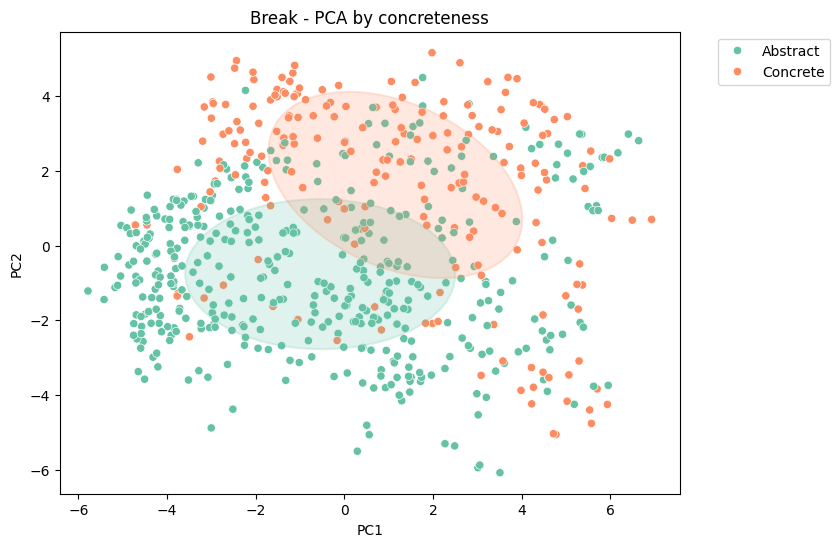

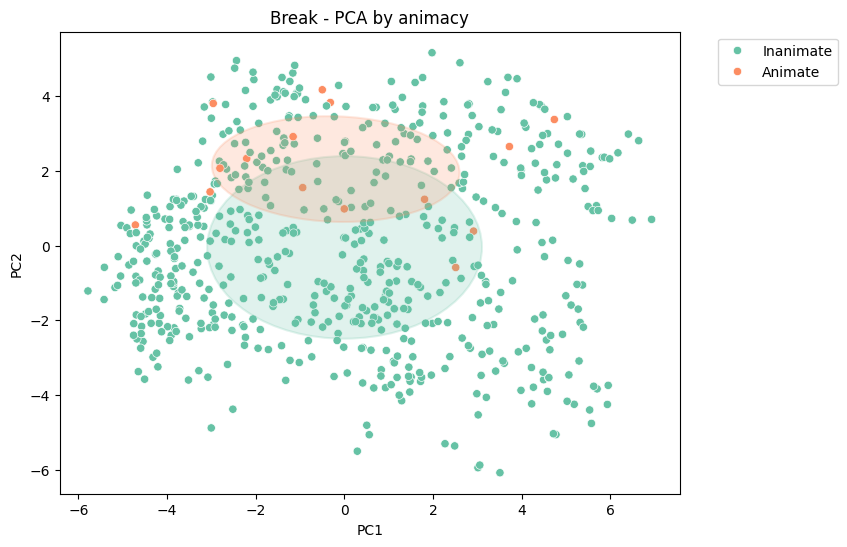

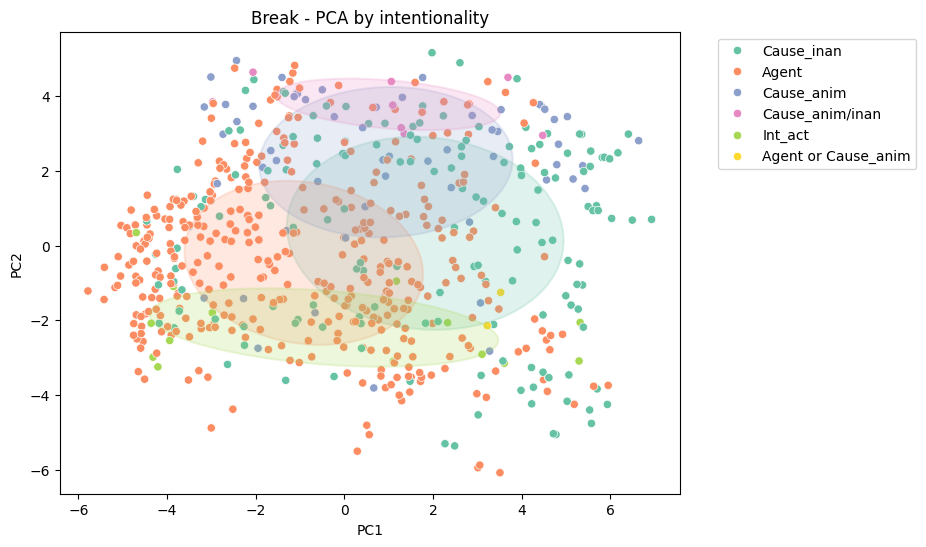

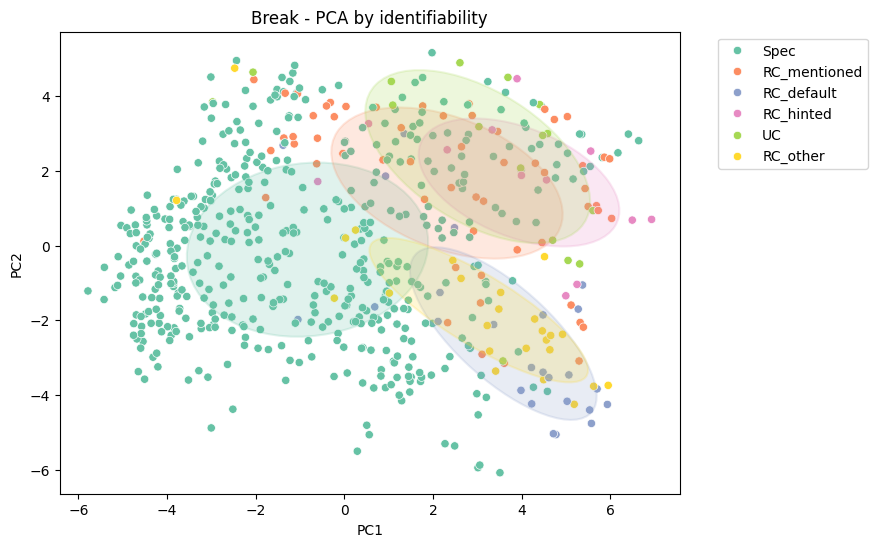


🔍 Analyzing verb: freeze


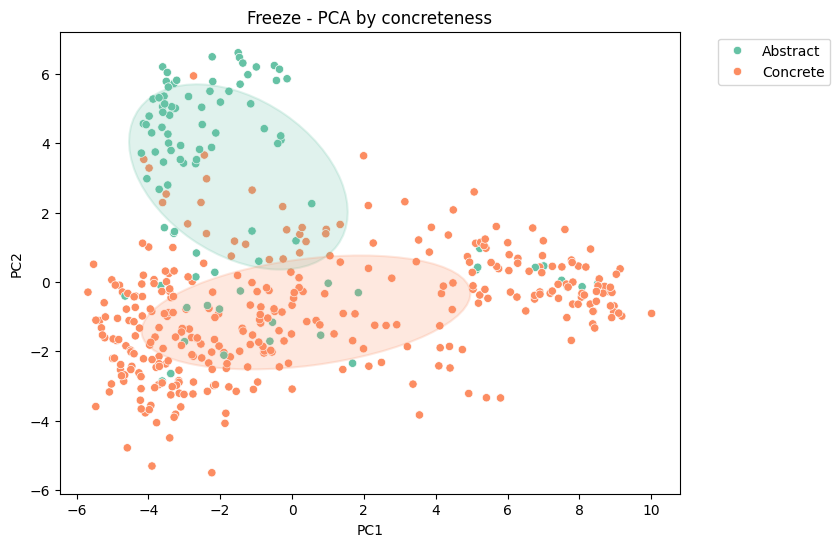

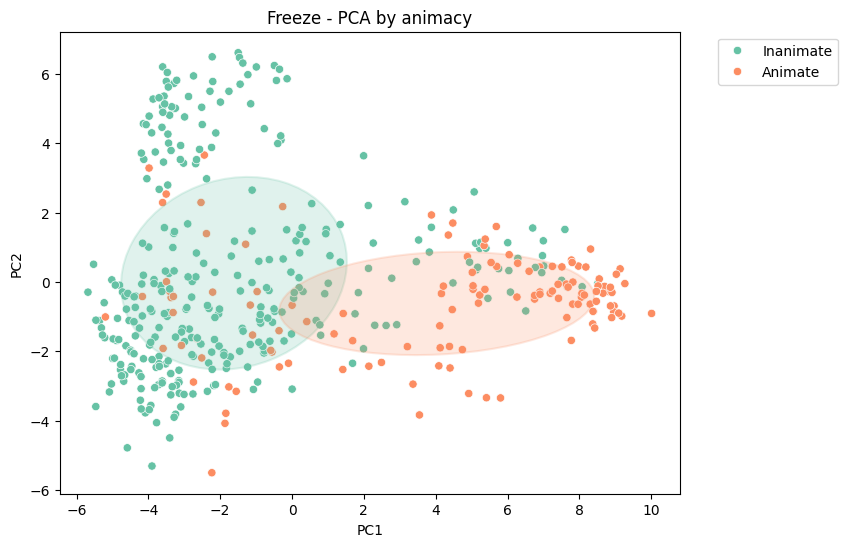

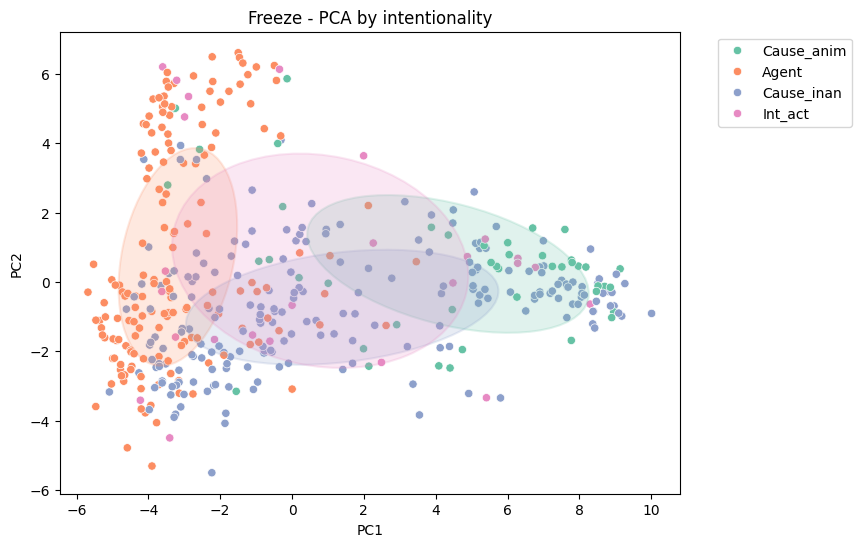

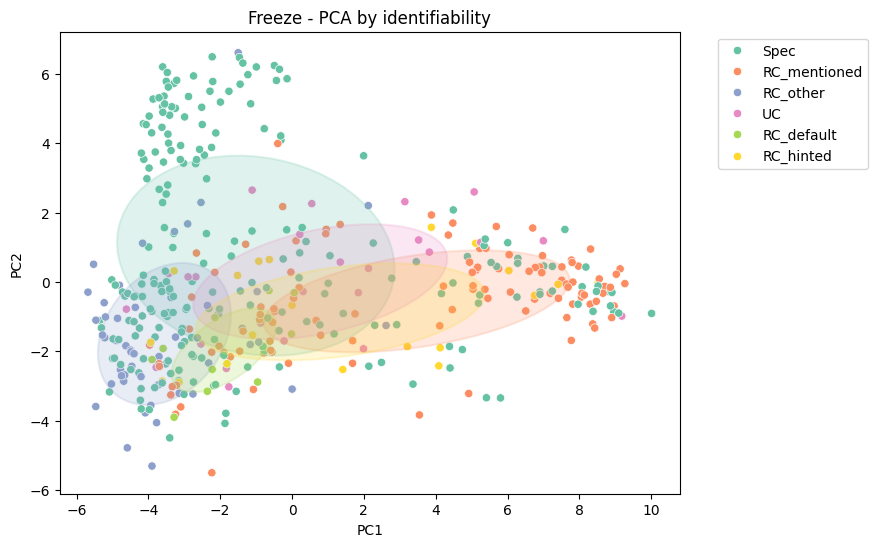

In [11]:
# 🔁 동사별 PCA 수행
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb}")
    sub_df = df[df['verb'] == verb].copy()

    # 임베딩만 추출
    X = sub_df.loc[:, '0':'767'].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    sub_df['PC1'], sub_df['PC2'] = pca_result[:, 0], pca_result[:, 1]

    # break 동사의 경우 Caus가 왼쪽에, NCaus가 오른쪽에 오도록 PC1 축을 조정
    if verb == 'break':
        caus_mean_pc1 = sub_df[sub_df['syntax'] == 'Caus']['PC1'].mean()
        ncaus_mean_pc1 = sub_df[sub_df['syntax'] == 'NCaus']['PC1'].mean()
        if caus_mean_pc1 > ncaus_mean_pc1:
            sub_df['PC1'] = -sub_df['PC1']


    # === sense/syntax 대신 G~J 열 반복 ===
    features_to_plot = [
        "concreteness", "animacy",
        "intentionality", "identifiability"
    ]

    for feature in features_to_plot:
        plt.figure(figsize=(8,6))
        plot = sns.scatterplot(x='PC1', y='PC2', hue=sub_df[feature], palette='Set2', data=sub_df)

        # Get the handles and labels from the legend
        handles, labels = plot.get_legend_handles_labels()

        # Create a dictionary to map labels to colors
        color_map = {}
        for label, handle in zip(labels, handles):
            if hasattr(handle, 'get_facecolor'):
                color_map[label] = handle.get_facecolor()[0]
            else:
                color_map[label] = handle.get_color()

        # 타원 추가
        for label in sub_df[feature].unique():
            subset = sub_df[sub_df[feature] == label]
            if len(subset) > 2:
                cov = np.cov(subset[['PC1','PC2']].T)
                eigvals, eigvecs = np.linalg.eigh(cov)
                order = eigvals.argsort()[::-1]
                eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                width, height = 2 * np.sqrt(eigvals)
                ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                  width, height, angle=angle, edgecolor=color_map[label], facecolor=color_map[label], alpha=0.2, lw=1.5) # Added facecolor and alpha
                plt.gca().add_patch(ellipse)

        plt.title(f"{verb.capitalize()} - PCA by {feature}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

# Task
Generate PCA plots for 'break' and 'freeze' verbs, separately for 'Caus' and 'NCaus' embeddings, analyzing 'concreteness', 'intentionality', and 'identifiability'. For each plot, highlight the active syntax ('Caus' or 'NCaus') with colored points and ellipses, while displaying the inactive syntax in light gray. Add titles and legends to each plot. Do not modify the existing code, add new code below it.

## Filter data

### Subtask:
Create separate dataframes for 'break' and 'freeze' verbs, and then filter these dataframes further to create 'Caus' and 'NCaus' subsets for each verb.


**Reasoning**:
The subtask requires creating separate dataframes for each verb and then splitting them based on syntax. This can be done by filtering the main dataframe.



In [ ]:
# Create dataframes for each verb
break_df = df[df['verb'] == 'break'].copy()
freeze_df = df[df['verb'] == 'freeze'].copy()

# Create dataframes for each syntax within each verb dataframe
break_caus_df = break_df[break_df['syntax'] == 'Caus'].copy()
break_ncaus_df = break_df[break_df['syntax'] == 'NCaus'].copy()

freeze_caus_df = freeze_df[freeze_df['syntax'] == 'Caus'].copy()
freeze_ncaus_df = freeze_df[freeze_df['syntax'] == 'NCaus'].copy()

## Perform pca

### Subtask:
For each of the four subsets (break-Caus, break-NCaus, freeze-Caus, freeze-NCaus), perform PCA to reduce the dimensions to 2.


**Reasoning**:
The subtask requires performing PCA on the embedding columns of four dataframes: `break_caus_df`, `break_ncaus_df`, `freeze_caus_df`, and `freeze_ncaus_df`. This will be done by extracting the embedding columns, applying PCA with 2 components, and adding the resulting components as new columns to each dataframe. This can be done in a single code block for all four dataframes.



In [ ]:
# Function to perform PCA and add results to dataframe
def apply_pca_and_add_components(dataframe, n_components=2):
    """Applies PCA to embedding columns and adds resulting components to dataframe."""
    X = dataframe.loc[:, '0':'767'].values
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(X)
    dataframe['PC1'] = pca_result[:, 0]
    dataframe['PC2'] = pca_result[:, 1]
    return dataframe

# Apply PCA to each dataframe
break_caus_df = apply_pca_and_add_components(break_caus_df)
break_ncaus_df = apply_pca_and_add_components(break_ncaus_df)
freeze_caus_df = apply_pca_and_add_components(freeze_caus_df)
freeze_ncaus_df = apply_pca_and_add_components(freeze_ncaus_df)

# Display the first few rows of each updated dataframe to verify
print("Break Causative with PCA:")
display(break_caus_df.head())
print("\nBreak Non-Causative with PCA:")
display(break_ncaus_df.head())
print("\nFreeze Causative with PCA:")
display(freeze_caus_df.head())
print("\nFreeze Non-Causative with PCA:")
display(freeze_ncaus_df.head())

Break Causative with PCA:


,0,1,2,3,4,5,6,7,8,9,...,sense,syntax,sentence,concreteness,animacy,intentionality,identifiability,verb,PC1,PC2
0,-0.268296,0.515550,-0.036981,0.167487,0.746249,-0.043274,0.287072,0.187108,-0.310255,0.185969,...,destruction,Caus,"At a slight 5.2 pounds and $2,999, it won't br...",Abstract,Inanimate,Cause_inan,Spec,break,-1.496664,3.896493
1,0.279771,0.427525,0.143628,0.469398,0.902733,-0.045868,-0.058215,-0.004533,-0.140621,0.154119,...,termination,Caus,We just can't seem to break our addiction to t...,Abstract,Inanimate,Agent,Spec,break,-4.528840,-1.545711
2,-0.020743,0.409262,0.079372,1.068581,1.152672,-0.147916,0.561047,0.468974,-0.443480,-0.094427,...,termination,Caus,and if we were to give tax credits to builders...,Abstract,Inanimate,Agent,Spec,break,-4.472628,-1.794932
3,-0.080311,0.102309,-0.114360,0.708209,0.477703,-0.529139,0.313383,-0.093366,-0.623287,-0.202924,...,termination,Caus,we need to break our addiction to imported oil...,Abstract,Inanimate,Agent,Spec,break,-4.749498,-2.264920
4,-0.194344,0.342621,0.341211,0.876533,0.969503,-0.255095,0.202830,0.644163,-0.520722,0.071789,...,termination,Caus,The feds say biofuel will break our addiction ...,Abstract,Inanimate,Cause_inan,Spec,break,-3.637279,-2.217005



Break Non-Causative with PCA:


,0,1,2,3,4,5,6,7,8,9,...,sense,syntax,sentence,concreteness,animacy,intentionality,identifiability,verb,PC1,PC2
6,-0.410170,0.683200,-0.239018,0.385605,-0.117709,0.316239,0.429639,-0.161682,-0.537351,0.315698,...,destruction,NCaus,I hit it sharply a couple of times with a hamm...,Concrete,Inanimate,Agent,RC_mentioned,break,4.989128,-0.087279
9,0.185220,0.962349,-0.046931,0.107868,0.506634,0.114088,0.524079,0.419785,-0.590482,0.088870,...,bodily harm,NCaus,"As ANNIE swings, the sledgehammer makes contac...",Concrete,Inanimate,Cause_anim,RC_mentioned,break,5.148748,-0.476124
26,0.148309,0.512865,-0.205588,0.536856,0.434499,-0.317546,0.190902,0.965465,-0.077115,0.597936,...,destruction,NCaus,"When night came, Steve spun his ball on his fi...",Concrete,Inanimate,Cause_anim,RC_mentioned,break,3.498585,0.015225
28,0.453731,0.002015,0.119987,0.076050,-0.143623,0.356522,0.008701,1.081445,-0.109593,0.498537,...,destruction,NCaus,The banks of the creek broke by three in the a...,Concrete,Inanimate,Cause_inan,RC_mentioned,break,-0.402883,-0.780790
49,0.376587,0.720411,0.113565,0.340995,0.862519,-0.046069,0.474648,0.134953,-0.122575,0.518339,...,destruction,NCaus,"Over time, the bells break and become stuck in...",Concrete,Inanimate,Cause_inan,RC_default,break,5.162543,-0.072423



Freeze Causative with PCA:


,0,1,2,3,4,5,6,7,8,9,...,sense,syntax,sentence,concreteness,animacy,intentionality,identifiability,verb,PC1,PC2
620,0.739813,-0.161534,0.159807,-0.021846,0.615757,-0.152563,-0.226565,0.658392,-0.214025,0.208461,...,economical freezing,Caus,But LeAnn Rimes needs to freeze her Twitter ac...,Abstract,Inanimate,Cause_anim,Spec,freeze,-1.529761,-1.005320
621,0.286839,-0.022888,0.030209,0.469752,0.485945,-0.445443,-0.012678,1.292707,-0.550500,0.563164,...,economical freezing,Caus,In an appalling and impossible to explain fail...,Abstract,Inanimate,Cause_anim,Spec,freeze,-4.905126,1.217909
622,-0.081794,0.492251,-0.241870,0.228848,0.730818,-0.412775,0.082624,1.151912,-1.261438,0.824931,...,economical freezing,Caus,"In effect, it freezes the accounts of househol...",Abstract,Inanimate,Agent,Spec,freeze,-4.896021,-1.046734
623,-0.108310,-0.072093,0.023580,0.270901,0.774976,-0.187142,-0.259545,0.636596,-0.552170,0.875804,...,economical freezing,Caus,financial institutions that had been instructe...,Abstract,Inanimate,Agent,Spec,freeze,-4.423737,-2.360811
624,0.350374,0.354093,0.125614,0.090218,0.972341,-0.706027,0.193743,0.607897,-0.300775,0.592583,...,economical freezing,Caus,"The bank said it was participating in "" a regu...",Abstract,Inanimate,Agent,Spec,freeze,-4.449122,-2.770742



Freeze Non-Causative with PCA:


,0,1,2,3,4,5,6,7,8,9,...,sense,syntax,sentence,concreteness,animacy,intentionality,identifiability,verb,PC1,PC2
628,0.759850,0.034401,-0.243624,-0.258892,-0.224188,-0.099509,0.053985,1.116014,-0.564675,1.163904,...,immobilization,NCaus,The air around him froze and so did he.,Concrete,Inanimate,Cause_inan,RC_mentioned,freeze,2.952166,-1.629241
646,0.442213,0.183491,0.426439,0.360881,0.206806,-0.103009,0.551511,0.700640,0.083784,0.236974,...,physical freezing,NCaus,"Norwegian Fridtjof Nansen allowed his boat, th...",Concrete,Inanimate,Cause_inan,RC_mentioned,freeze,-5.577563,0.522220
647,0.468894,0.175172,0.399186,0.046918,-0.472144,0.209136,0.115908,0.823152,-0.628436,0.850025,...,emotional/mental freezing,NCaus,"""Leap, run, fly,"" but my body froze and shiver...",Concrete,Inanimate,Cause_inan,RC_mentioned,freeze,2.742724,-1.663420
649,0.029378,-0.394743,-0.054291,0.451889,0.688901,0.054953,0.904614,1.262444,-0.292885,0.707952,...,physical freezing,NCaus,Hillary discovered that his boots had frozen a...,Concrete,Inanimate,Cause_inan,RC_mentioned,freeze,-5.376672,-2.889520
650,0.221074,0.604704,-0.181033,-0.306481,-0.354255,-0.035936,-0.038392,1.037664,-0.483508,0.535708,...,emotional/mental freezing,NCaus,He saw how the boy froze --- how his face grew...,Concrete,Animate,Cause_inan,RC_mentioned,freeze,4.336312,0.437069


## Generate plots

### Subtask:
For each subset and each of the specified features ('concreteness', 'intentionality', 'identifiability'), generate a scatter plot of the PCA results.


**Reasoning**:
Iterate through verbs, syntaxes, and features to generate PCA plots for each combination, highlighting the active syntax and displaying the inactive syntax in light gray, adding titles and legends.




🔍 Analyzing verb: break
  ▶️ Active Syntax: Caus


AttributeError: module 'matplotlib.pyplot' has no attribute 'collections'

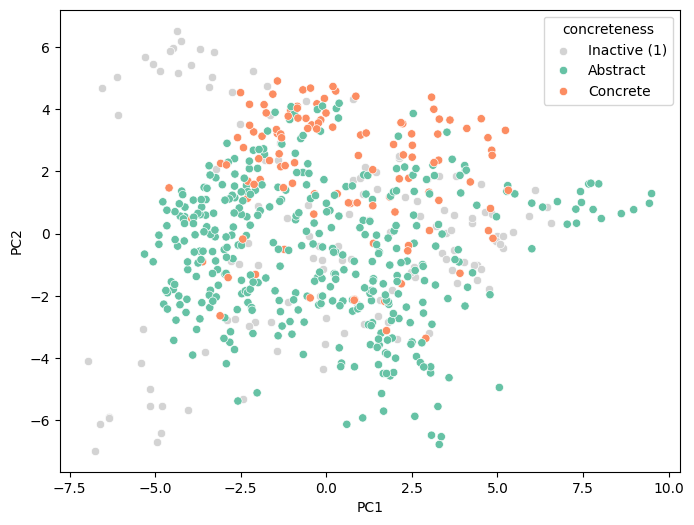

In [ ]:
verbs_to_analyze = ["break", "freeze"]
syntaxes_to_analyze = ["Caus", "NCaus"]
features_to_plot = ["concreteness", "intentionality", "identifiability"]

# Iterate through verbs and syntaxes
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb}")
    for active_syntax in syntaxes_to_analyze:
        print(f"  ▶️ Active Syntax: {active_syntax}")

        # Determine active and inactive dataframes
        if verb == "break":
            active_df = break_caus_df if active_syntax == "Caus" else break_ncaus_df
            inactive_df = break_ncaus_df if active_syntax == "Caus" else break_caus_df
        elif verb == "freeze":
            active_df = freeze_caus_df if active_syntax == "Caus" else freeze_ncaus_df
            inactive_df = freeze_ncaus_df if active_syntax == "Caus" else freeze_caus_df

        # Iterate through features to plot
        for feature in features_to_plot:
            plt.figure(figsize=(8, 6))

            # Plot inactive syntax in light gray
            sns.scatterplot(x='PC1', y='PC2', color='lightgray', data=inactive_df, label=f'Inactive ({1 if active_syntax == "Caus" else 0})', legend=False)

            # Plot active syntax with hue based on the feature
            plot = sns.scatterplot(x='PC1', y='PC2', hue=active_df[feature], palette='Set2', data=active_df)

            # Get the handles and labels from the legend for ellipse colors
            handles, labels = plot.get_legend_handles_labels()
            color_map = {}
            for label, handle in zip(labels, handles):
                 # Check if handle is a PathCollection (for scatterplot points)
                if isinstance(handle, plt.collections.PathCollection):
                    color_map[label] = handle.get_facecolor()[0]
                elif isinstance(handle, plt.Line2D):
                     # Handle for Line2D objects (like in legend for single colors)
                    color_map[label] = handle.get_color()


            # Add ellipses for the active syntax feature categories
            for label in active_df[feature].unique():
                subset = active_df[active_df[feature] == label]
                if len(subset) > 2:
                    cov = np.cov(subset[['PC1','PC2']].T)
                    eigvals, eigvecs = np.linalg.eigh(cov)
                    order = eigvals.argsort()[::-1]
                    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                    width, height = 2 * np.sqrt(eigvals)
                    ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                      width, height, angle=angle, edgecolor=color_map.get(label, 'black'), facecolor=color_map.get(label, 'black'), alpha=0.2, lw=1.5)
                    plt.gca().add_patch(ellipse)

            plt.title(f"{verb.capitalize()} - Active {active_syntax} - PCA by {feature}")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

**Reasoning**:
The error `AttributeError: module 'matplotlib.pyplot' has no attribute 'collections'` indicates that `plt.collections` is not the correct way to check the type of legend handles. The correct way is to import `PathCollection` from `matplotlib.collections` and check against that.




🔍 Analyzing verb: break
  ▶️ Active Syntax: Caus


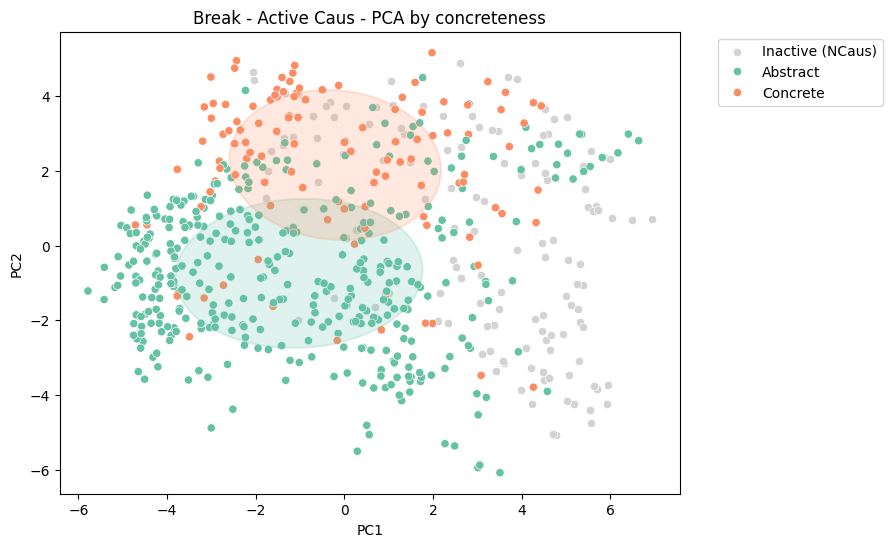

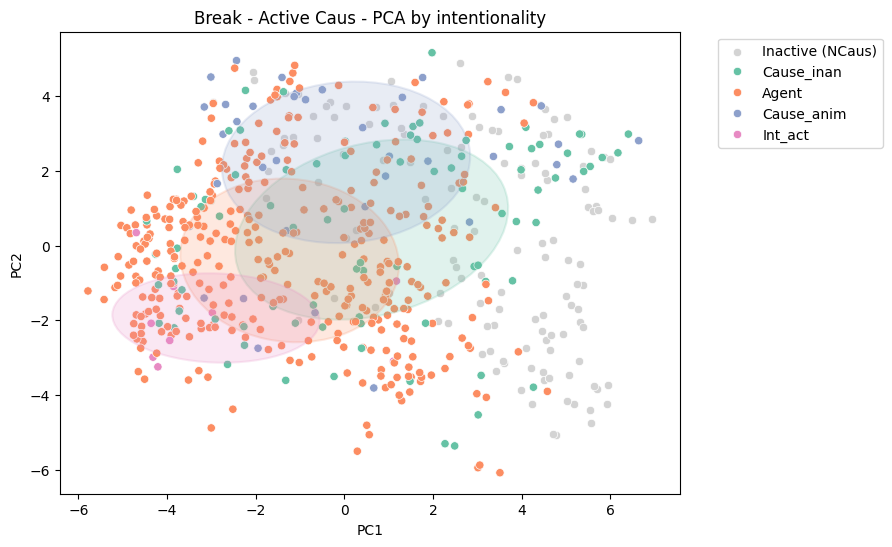

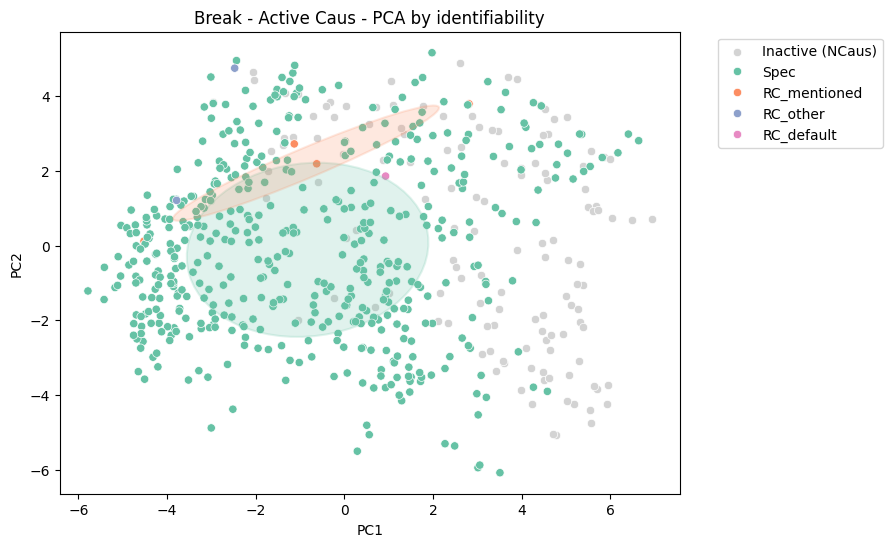

  ▶️ Active Syntax: NCaus


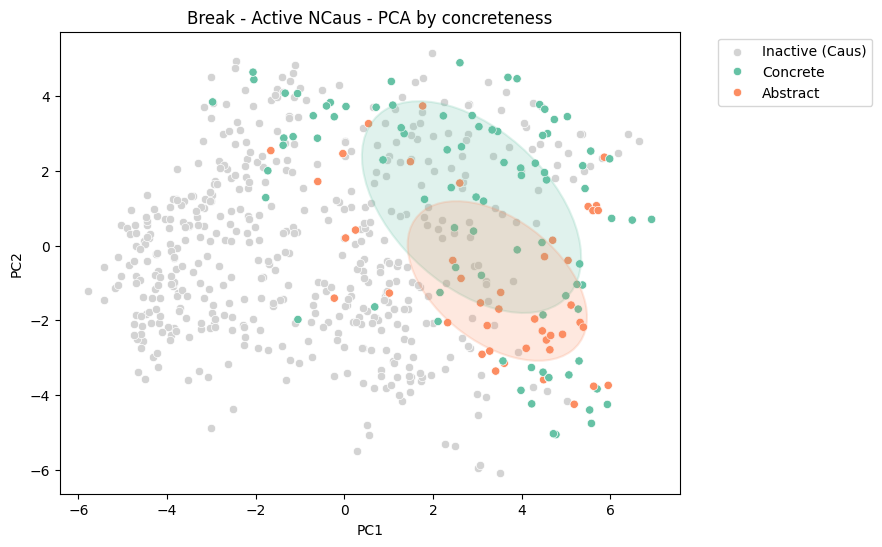

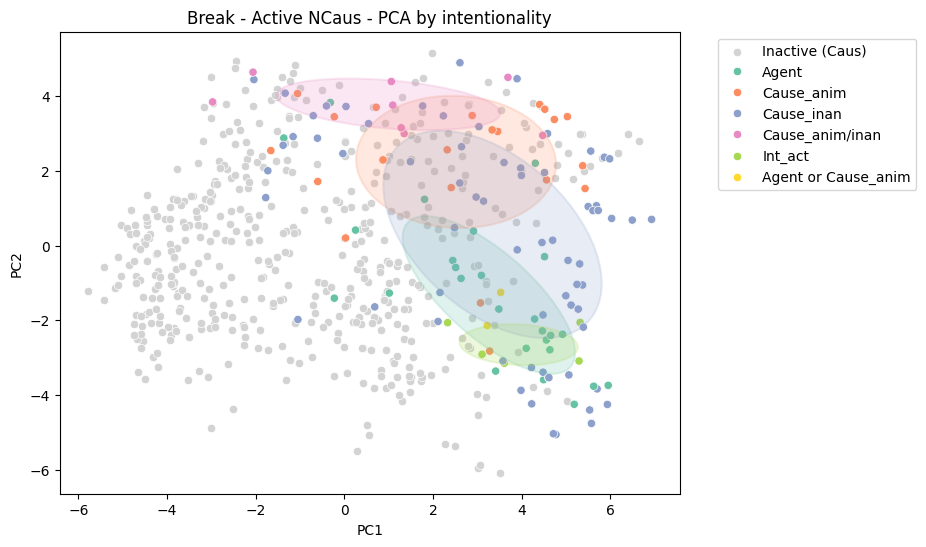

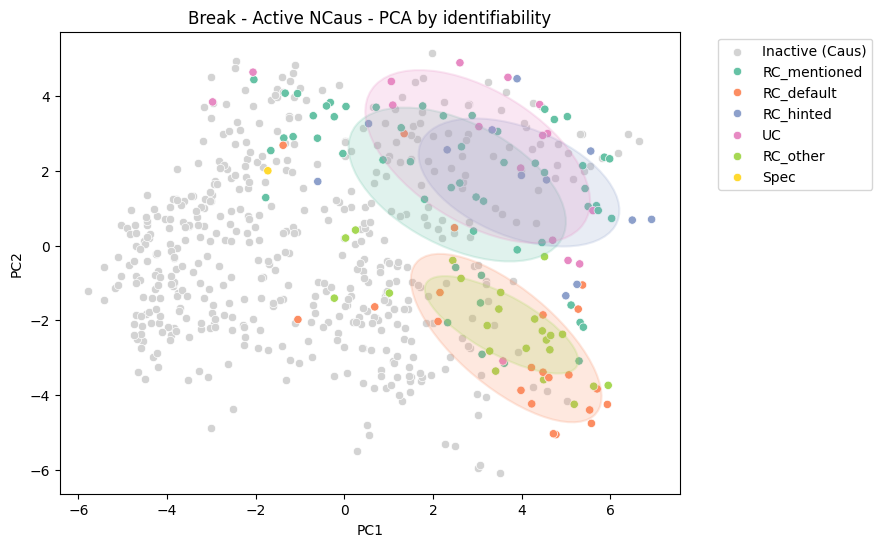


🔍 Analyzing verb: freeze
  ▶️ Active Syntax: Caus


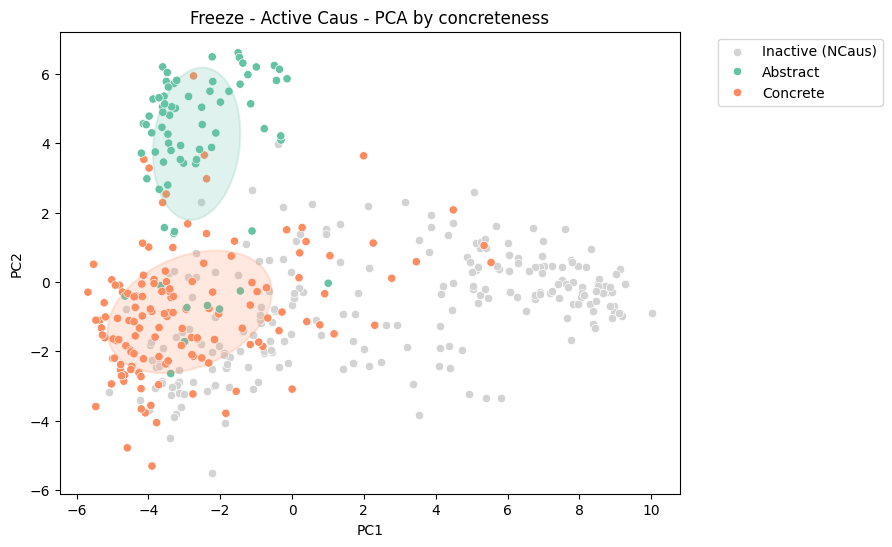

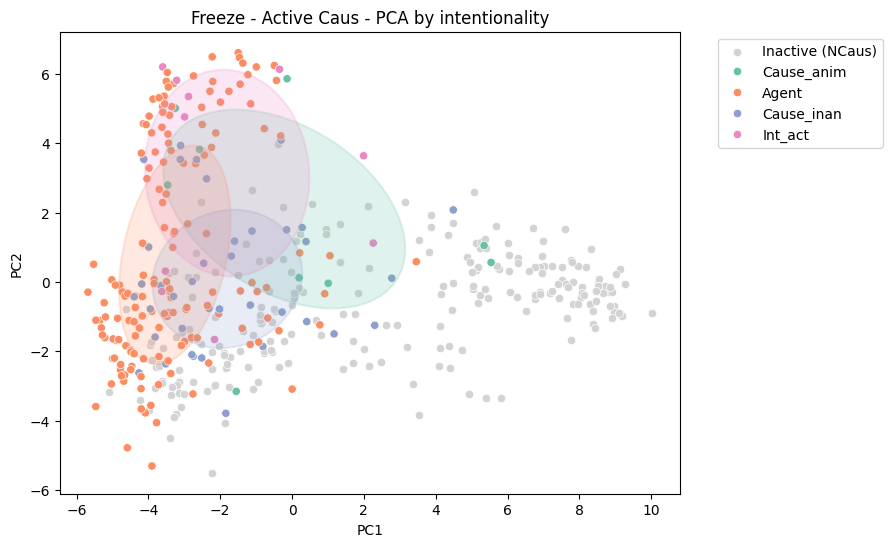

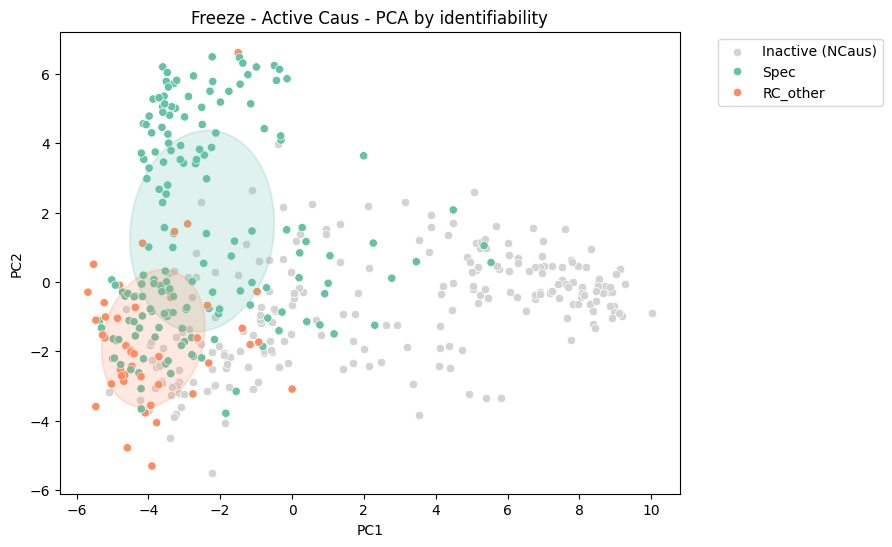

  ▶️ Active Syntax: NCaus


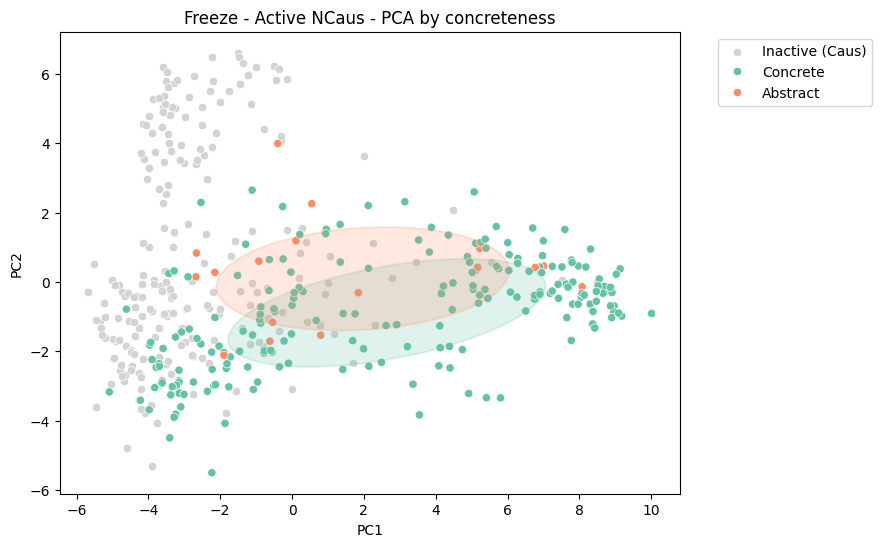

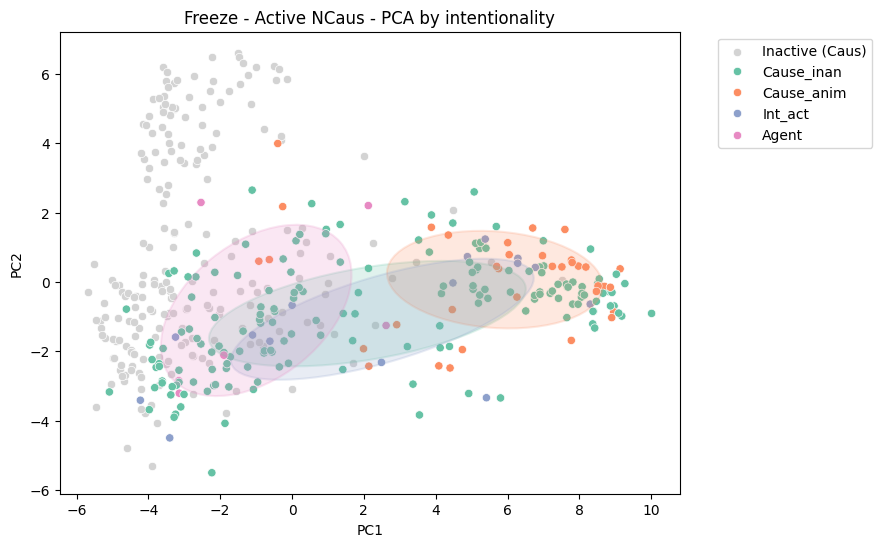

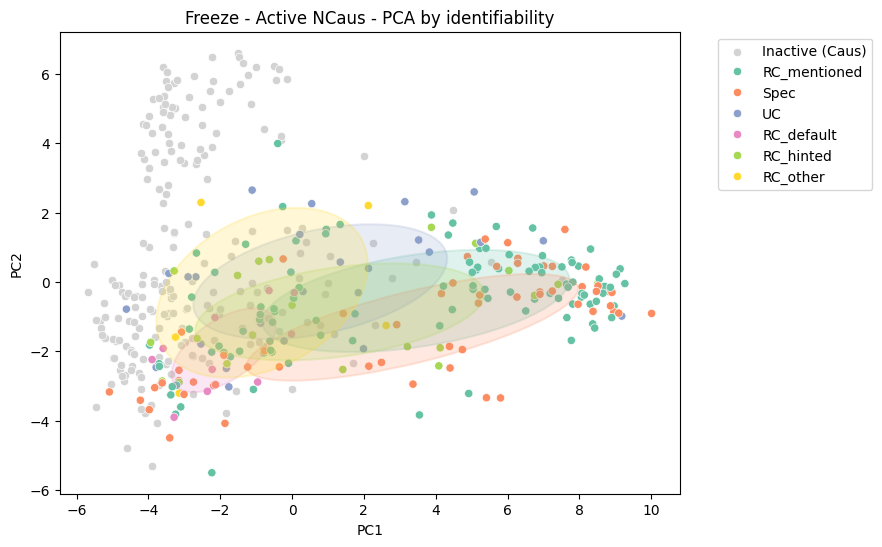

In [12]:
from matplotlib.collections import PathCollection
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import numpy as np

verbs_to_analyze = ["break", "freeze"]
syntaxes_to_analyze = ["Caus", "NCaus"]
features_to_plot = ["concreteness", "intentionality", "identifiability"]

# Perform PCA once for each verb on the combined data
pca_results = {}
for verb in verbs_to_analyze:
    sub_df = df[df['verb'] == verb].copy()
    X = sub_df.loc[:, '0':'767'].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    sub_df['PC1'] = pca_result[:, 0]
    sub_df['PC2'] = pca_result[:, 1]
    pca_results[verb] = sub_df

# Now, iterate through verbs and syntaxes for plotting
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb}")

    # Get the PCA results for the current verb
    sub_df_pca = pca_results[verb].copy()

    # Determine if PC1 needs to be flipped for this verb for the desired orientation
    # This is done based on the mean PC1 of Caus and NCaus for the *break* verb
    flip_pc1 = False
    if verb == 'break':
        caus_mean_pc1 = sub_df_pca[sub_df_pca['syntax'] == 'Caus']['PC1'].mean()
        ncaus_mean_pc1 = sub_df_pca[sub_df_pca['syntax'] == 'NCaus']['PC1'].mean()
        # For 'break', we want Caus on the left (smaller PC1) and NCaus on the right (larger PC1)
        # Flip if Caus mean is greater than NCaus mean
        if caus_mean_pc1 > ncaus_mean_pc1:
             flip_pc1 = True

    # Apply the potential flip to the PC1 values for this verb's data
    if flip_pc1:
        sub_df_pca['PC1'] = -sub_df_pca['PC1']


    for active_syntax in syntaxes_to_analyze:
        print(f"  ▶️ Active Syntax: {active_syntax}")

        # Create active and inactive dataframes using the potentially flipped PC1
        active_df = sub_df_pca[sub_df_pca['syntax'] == active_syntax].copy()
        inactive_df = sub_df_pca[sub_df_pca['syntax'] != active_syntax].copy()


        # Iterate through features to plot
        for feature in features_to_plot:
            plt.figure(figsize=(8, 6))

            # Plot inactive syntax in light gray using the potentially flipped PC1
            sns.scatterplot(x='PC1', y='PC2', color='lightgray', data=inactive_df, label=f'Inactive ({inactive_df["syntax"].iloc[0] if not inactive_df.empty else "N/A"})', legend=False)

            # Plot active syntax with hue based on the feature using the potentially flipped PC1
            plot = sns.scatterplot(x='PC1', y='PC2', hue=active_df[feature], palette='Set2', data=active_df)

            # Get the handles and labels from the legend for ellipse colors
            handles, labels = plot.get_legend_handles_labels()
            color_map = {}
            # Start from index 1 to skip the 'Inactive' label added by the first scatterplot
            for label, handle in zip(labels[1:], handles[1:]):
                 # Check if handle is a PathCollection (for scatterplot points)
                if isinstance(handle, PathCollection):
                    color_map[label] = handle.get_facecolor()[0]
                elif isinstance(handle, plt.Line2D):
                     # Handle for Line2D objects (like in legend for single colors)
                    color_map[label] = handle.get_color()


            # Add ellipses for the active syntax feature categories using the potentially flipped PC1
            for label in active_df[feature].unique():
                subset = active_df[active_df[feature] == label]
                if len(subset) > 2:
                    cov = np.cov(subset[['PC1','PC2']].T)
                    eigvals, eigvecs = np.linalg.eigh(cov)
                    order = eigvals.argsort()[::-1]
                    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                    width, height = 2 * np.sqrt(eigvals)
                    ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                      width, height, angle=angle, edgecolor=color_map.get(label, 'black'), facecolor=color_map.get(label, 'black'), alpha=0.2, lw=1.5)
                    plt.gca().add_patch(ellipse)

            plt.xlabel('PC1') # Label remains PC1 even if flipped
            plt.ylabel('PC2') # Label remains PC2
            plt.title(f"{verb.capitalize()} - Active {active_syntax} - PCA by {feature}")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

## Summary:

### Data Analysis Key Findings

*   The analysis successfully generated 12 PCA plots, visualizing the distribution of verb embeddings for 'break' and 'freeze' verbs under 'Caus' and 'NCaus' syntactic structures.
*   Each plot effectively displayed the PCA components (PC1 and PC2), highlighting the active syntax with colored points and ellipses based on 'concreteness', 'intentionality', or 'identifiability', while the inactive syntax was shown in light gray.
*   Ellipses were successfully drawn around the clusters of active syntax data points for each category of the analyzed feature, providing a visual representation of their distribution in the PCA space.

### Insights or Next Steps

*   Analyze the generated PCA plots to identify potential clustering patterns or separations in the embeddings based on the features ('concreteness', 'intentionality', 'identifiability') and syntactic structures ('Caus' vs. 'NCaus').
*   Quantify the separation between clusters using metrics like silhouette scores or inter-cluster distance to provide a more rigorous analysis of the observed patterns.


### Additional PCA Plots by Sense

Based on your request, I will now generate additional PCA plots focusing on the 'sense' feature for both 'break' and 'freeze' verbs, with separate visualizations for active 'Caus' and active 'NCaus' syntaxes.


🔍 Analyzing verb: break (by sense)
  ▶️ Active Syntax: Caus


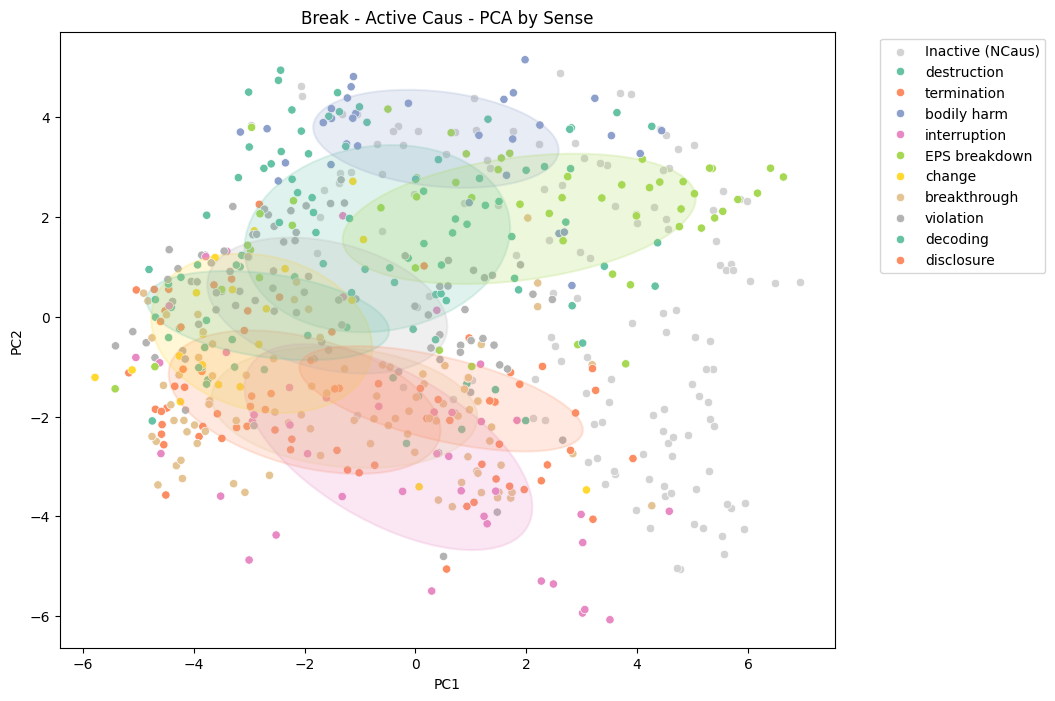

  ▶️ Active Syntax: NCaus


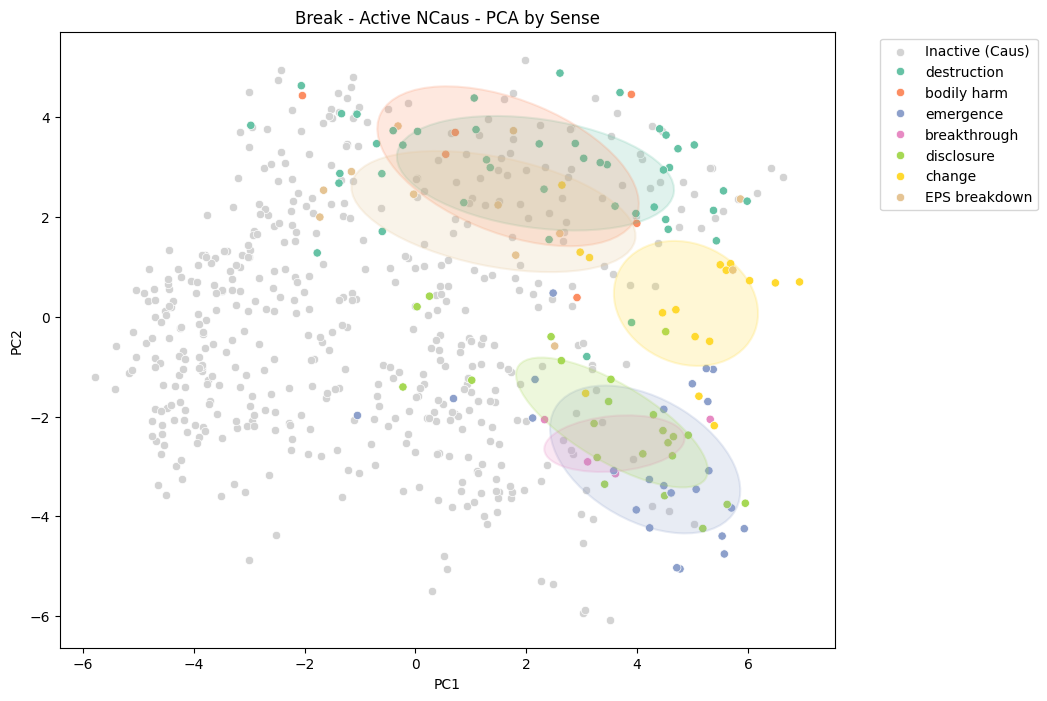


🔍 Analyzing verb: freeze (by sense)
  ▶️ Active Syntax: Caus


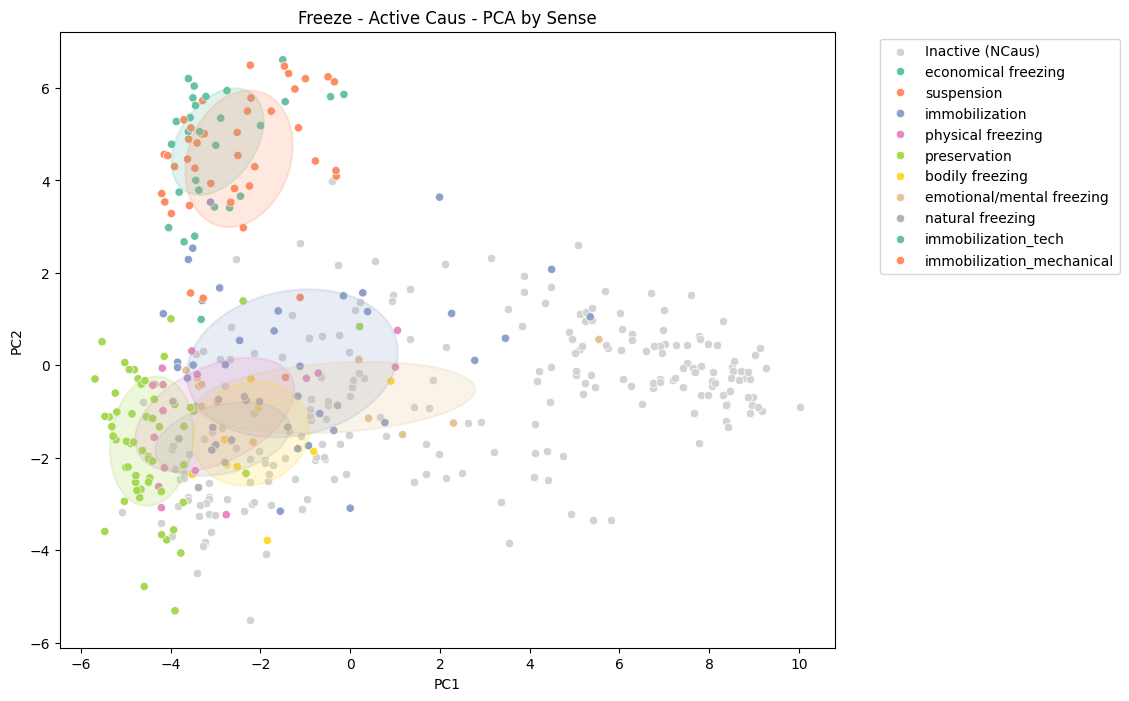

  ▶️ Active Syntax: NCaus


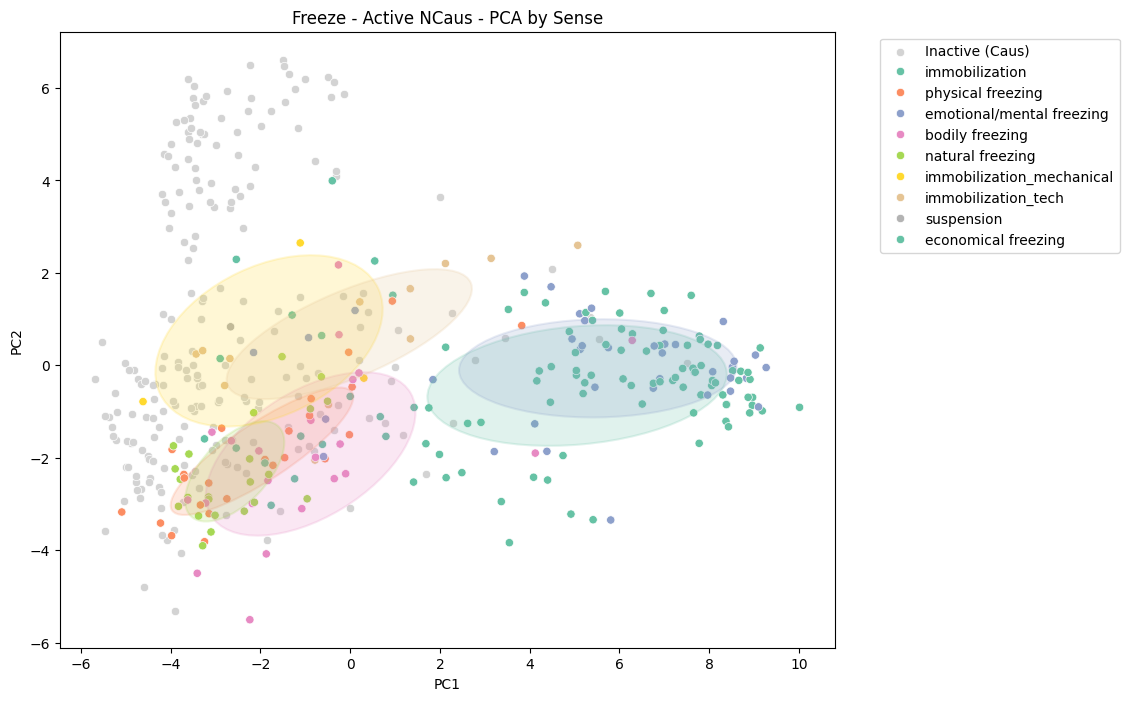

In [13]:
# Add 'sense' to the list of features to plot for this specific request
features_to_plot_sense = ["sense"]

# Iterate through verbs and syntaxes for plotting the 'sense' feature
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb} (by sense)")

    # Get the PCA results for the current verb (already calculated and potentially flipped)
    sub_df_pca = pca_results[verb].copy()

    for active_syntax in syntaxes_to_analyze:
        print(f"  ▶️ Active Syntax: {active_syntax}")

        # Create active and inactive dataframes using the potentially flipped PC1
        active_df = sub_df_pca[sub_df_pca['syntax'] == active_syntax].copy()
        inactive_df = sub_df_pca[sub_df_pca['syntax'] != active_syntax].copy()

        # Iterate through the 'sense' feature
        for feature in features_to_plot_sense:
            plt.figure(figsize=(10, 8)) # Increased figure size for better readability with more sense labels

            # Plot inactive syntax in light gray using the potentially flipped PC1
            sns.scatterplot(x='PC1', y='PC2', color='lightgray', data=inactive_df, label=f'Inactive ({inactive_df["syntax"].iloc[0] if not inactive_df.empty else "N/A"})', legend=False)

            # Plot active syntax with hue based on the 'sense' feature using the potentially flipped PC1
            plot = sns.scatterplot(x='PC1', y='PC2', hue=active_df[feature], palette='Set2', data=active_df)

            # Get the handles and labels from the legend for ellipse colors
            handles, labels = plot.get_legend_handles_labels()
            color_map = {}
            # Start from index 1 to skip the 'Inactive' label
            for label, handle in zip(labels[1:], handles[1:]):
                 # Check if handle is a PathCollection (for scatterplot points)
                if isinstance(handle, PathCollection):
                    color_map[label] = handle.get_facecolor()[0]
                elif isinstance(handle, plt.Line2D):
                     # Handle for Line2D objects (like in legend for single colors)
                    color_map[label] = handle.get_color()

            # Add ellipses for the active syntax 'sense' categories using the potentially flipped PC1
            for label in active_df[feature].unique():
                subset = active_df[active_df[feature] == label]
                if len(subset) > 2:
                    cov = np.cov(subset[['PC1','PC2']].T)
                    eigvals, eigvecs = np.linalg.eigh(cov)
                    order = eigvals.argsort()[::-1]
                    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                    width, height = 2 * np.sqrt(eigvals)
                    ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                      width, height, angle=angle, edgecolor=color_map.get(label, 'black'), facecolor=color_map.get(label, 'black'), alpha=0.2, lw=1.5)
                    plt.gca().add_patch(ellipse)

            plt.xlabel('PC1') # Label remains PC1 even if flipped
            plt.ylabel('PC2') # Label remains PC2
            plt.title(f"{verb.capitalize()} - Active {active_syntax} - PCA by {feature.capitalize()}")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()